# Trinucleotide Matrix Analysis Demo

This notebook demonstrates the `trinucleotideMatrix()` method for mutational signature analysis in pyMut.

The method generates a 96 x samples matrix representing trinucleotide contexts for all SNVs in the dataset.


## Setup and Imports


In [8]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add src to path if running from examples directory
if 'src' not in sys.path:
    sys.path.insert(0, '../../src')

from pyMut.input import read_maf
from pyMut.analysis.mutational_signature import add_trinucleotide_method_to_pymutation

# Add the method to PyMutation class
add_trinucleotide_method_to_pymutation()

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✓ Setup complete")


✓ Setup complete


## Data Loading


In [9]:
# Define file paths
maf_file = "../../src/pyMut/data/examples/tcga_laml.maf.gz"
fasta_file = "../../src/pyMut/data/resources/genome/GRCh38.p14.genome.fa"

# Check if files exist
if not os.path.exists(maf_file):
    print(f"❌ MAF file not found: {maf_file}")
else:
    print(f"✓ MAF file found")
    
if not os.path.exists(fasta_file):
    print(f"❌ FASTA file not found: {fasta_file}")
else:
    print(f"✓ FASTA file found")


✓ MAF file found
✓ FASTA file found


In [10]:
# Load the MAF file
pymut = read_maf(maf_file)

print(f"✓ Loaded {len(pymut.data):,} mutations")
print(f"✓ Data shape: {pymut.data.shape}")


2025-07-13 20:38:17,745 | INFO | pyMut.input | Starting MAF reading: ../../src/pyMut/data/examples/tcga_laml.maf.gz
2025-07-13 20:38:17,746 | INFO | pyMut.input | Loading from cache: ../../src/pyMut/data/examples/.pymut_cache/tcga_laml.maf_390b70c1a6ad2a7a.parquet
2025-07-13 20:38:17,762 | INFO | pyMut.input | Cache loaded successfully in 0.02 seconds


✓ Loaded 2,207 mutations
✓ Data shape: (2207, 216)


## Trinucleotide Matrix Generation


In [11]:
# Generate trinucleotide context matrix
contexts_df, enriched_data = pymut.trinucleotideMatrix(fasta_file)

print(f"✓ Generated {contexts_df.shape[0]} x {contexts_df.shape[1]} trinucleotide matrix")
print(f"✓ Processed {len(enriched_data):,} SNVs with valid contexts")
print(f"✓ Total mutations in matrix: {contexts_df.sum().sum():,}")


2025-07-13 20:38:17,800 | INFO | pyMut.analysis.mutational_signature | Detected long format with Tumor_Sample_Barcode column
2025-07-13 20:38:17,808 | INFO | pyMut.analysis.mutational_signature | Processing 2002 SNVs from 2207 total mutations
2025-07-13 20:38:17,811 | INFO | pyMut.analysis.mutational_signature | Loaded FASTA file: ../../src/pyMut/data/resources/genome/GRCh38.p14.genome.fa
2025-07-13 20:38:17,924 | INFO | pyMut.analysis.mutational_signature | Successfully processed 1987 SNVs with valid trinucleotide contexts
2025-07-13 20:38:18,109 | INFO | pyMut.analysis.mutational_signature | Generated 96 x 188 trinucleotide context matrix


✓ Generated 96 x 188 trinucleotide matrix
✓ Processed 1,987 SNVs with valid contexts
✓ Total mutations in matrix: 1,987


## Matrix Overview


In [12]:
# Basic statistics
total_mutations = contexts_df.sum().sum()
non_zero_contexts = (contexts_df > 0).sum().sum()
avg_mutations_per_sample = total_mutations / contexts_df.shape[1]

# Create summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Total Contexts', 'Total Samples', 'Total Mutations', 
               'Non-zero Contexts', 'Avg Mutations/Sample'],
    'Value': [contexts_df.shape[0], contexts_df.shape[1], total_mutations,
              non_zero_contexts, f"{avg_mutations_per_sample:.1f}"]
})

print("Matrix Summary:")
print(summary_stats.to_string(index=False))


Matrix Summary:
              Metric Value
      Total Contexts    96
       Total Samples   188
     Total Mutations  1987
   Non-zero Contexts  1709
Avg Mutations/Sample  10.6


## Top Trinucleotide Contexts


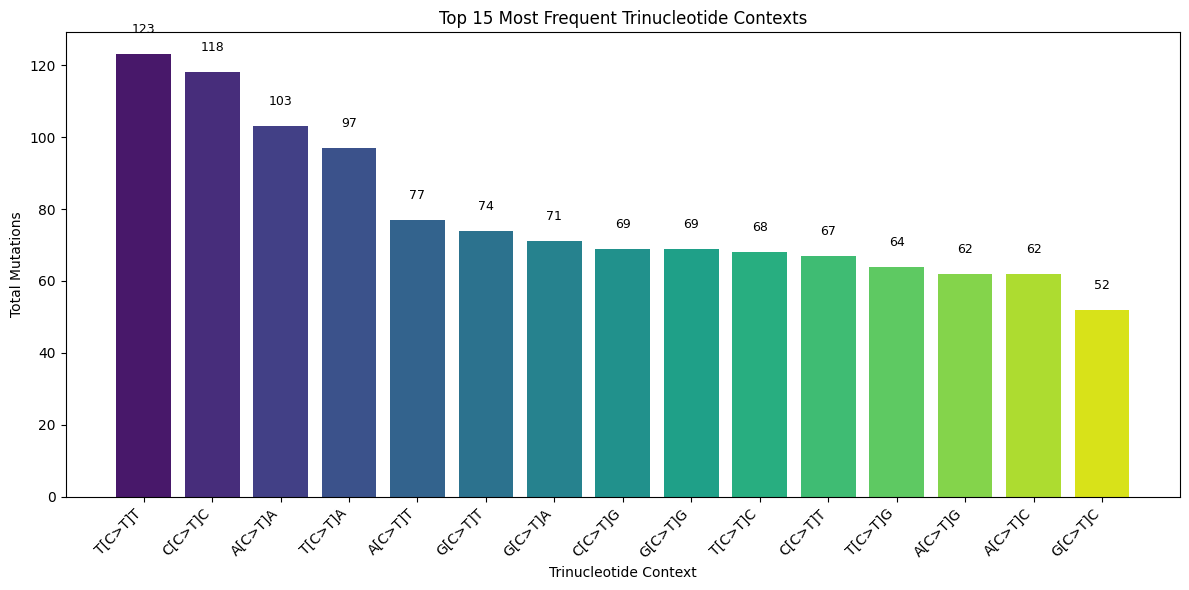

In [13]:
# Calculate context totals and plot top 15
context_totals = contexts_df.sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
top_contexts = context_totals.head(15)
bars = plt.bar(range(len(top_contexts)), top_contexts.values, 
               color=sns.color_palette("viridis", len(top_contexts)))
plt.xlabel('Trinucleotide Context')
plt.ylabel('Total Mutations')
plt.title('Top 15 Most Frequent Trinucleotide Contexts')
plt.xticks(range(len(top_contexts)), top_contexts.index, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Sample Distribution


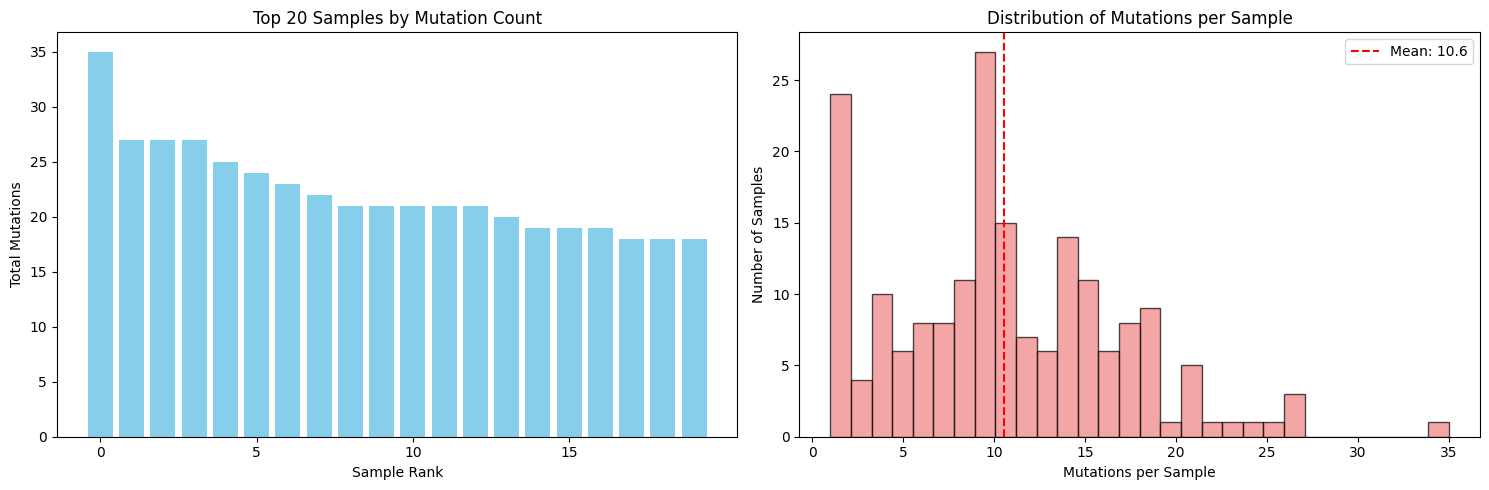

In [14]:
# Sample mutation counts
sample_totals = contexts_df.sum(axis=0).sort_values(ascending=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Top 20 samples
top_samples = sample_totals.head(20)
ax1.bar(range(len(top_samples)), top_samples.values, color='skyblue')
ax1.set_xlabel('Sample Rank')
ax1.set_ylabel('Total Mutations')
ax1.set_title('Top 20 Samples by Mutation Count')
ax1.set_xticks(range(0, len(top_samples), 5))

# Distribution histogram
ax2.hist(sample_totals.values, bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Mutations per Sample')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Distribution of Mutations per Sample')
ax2.axvline(sample_totals.mean(), color='red', linestyle='--', 
            label=f'Mean: {sample_totals.mean():.1f}')
ax2.legend()

plt.tight_layout()
plt.show()


## Mutation Type Distribution


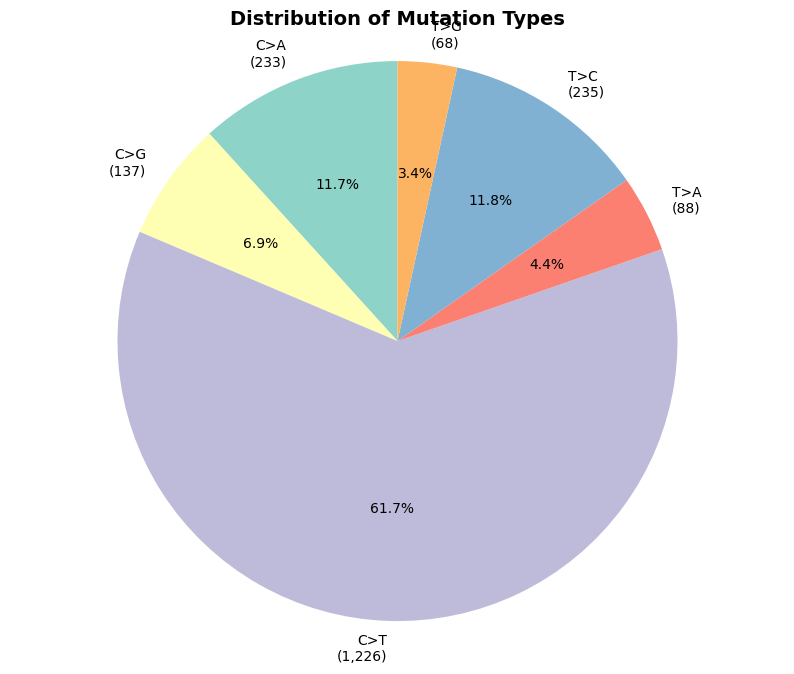

In [15]:
# Extract mutation types from context labels
mutation_types = []
for context in contexts_df.index:
    # Extract the mutation type from format "X[REF>ALT]Z"
    mutation_type = context.split('[')[1].split(']')[0]
    mutation_types.append(mutation_type)

# Group by mutation type
mutation_type_counts = {}
for i, mut_type in enumerate(mutation_types):
    if mut_type not in mutation_type_counts:
        mutation_type_counts[mut_type] = 0
    mutation_type_counts[mut_type] += contexts_df.iloc[i].sum()

# Create pie chart
plt.figure(figsize=(10, 8))
colors = sns.color_palette("Set3", len(mutation_type_counts))
wedges, texts, autotexts = plt.pie(mutation_type_counts.values(), 
                                   labels=mutation_type_counts.keys(),
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)

plt.title('Distribution of Mutation Types', fontsize=14, fontweight='bold')

# Add counts to labels
for i, (label, count) in enumerate(mutation_type_counts.items()):
    texts[i].set_text(f'{label}\n({count:,})')

plt.axis('equal')
plt.show()


## Trinucleotide Context Heatmap


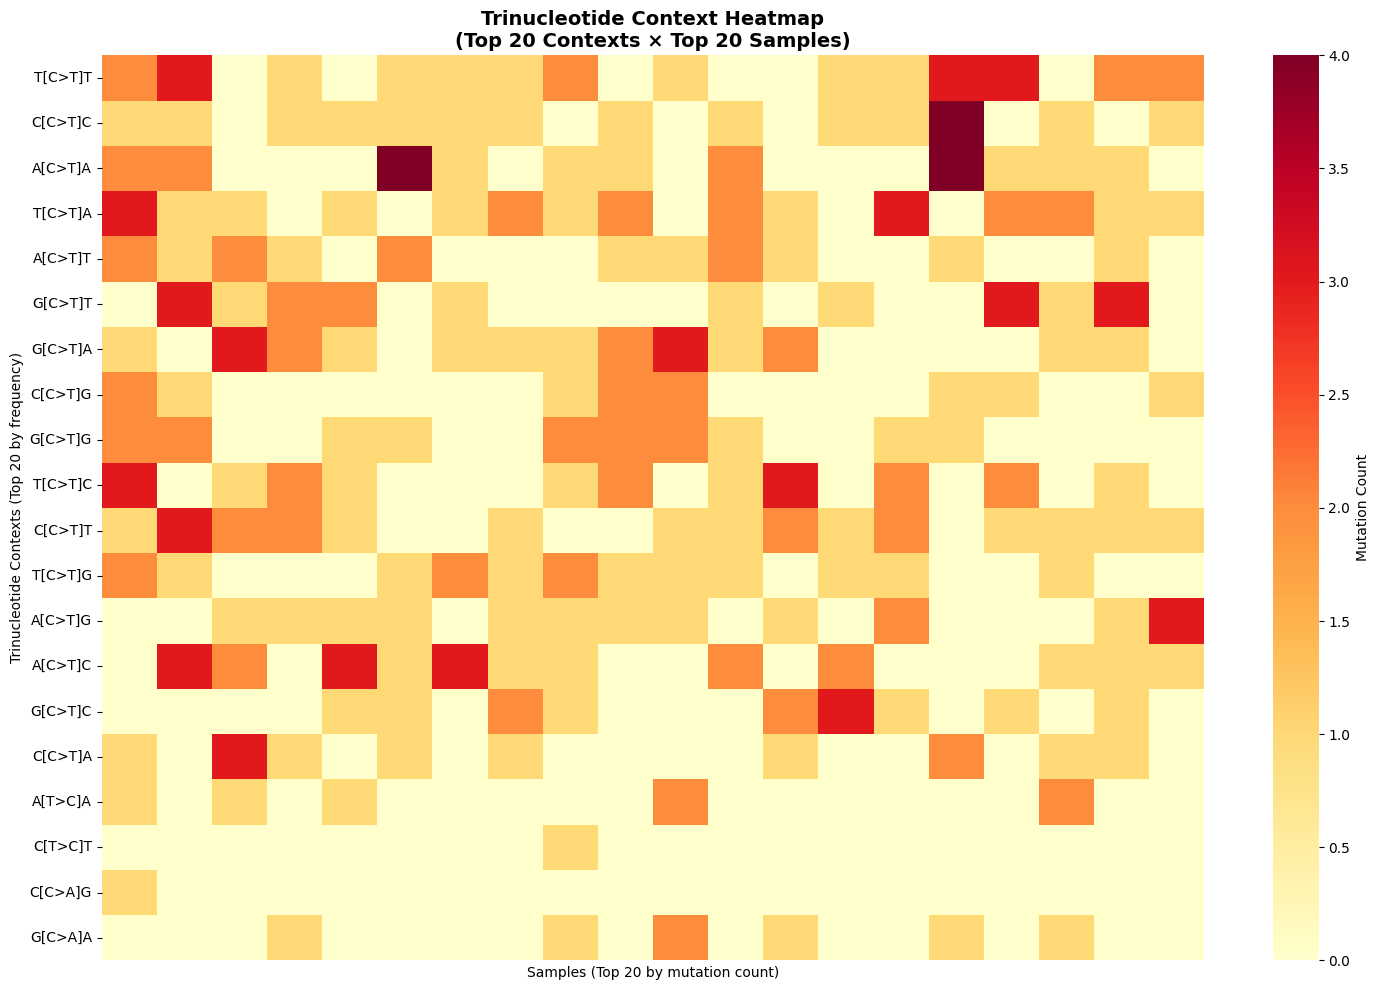

In [16]:
# Create a heatmap of the top contexts across top samples
top_20_contexts = context_totals.head(20).index
top_20_samples = sample_totals.head(20).index

# Subset the matrix
heatmap_data = contexts_df.loc[top_20_contexts, top_20_samples]

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, 
            cmap='YlOrRd',
            cbar_kws={'label': 'Mutation Count'},
            xticklabels=False,  # Hide sample names for clarity
            yticklabels=True)

plt.title('Trinucleotide Context Heatmap\n(Top 20 Contexts × Top 20 Samples)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Samples (Top 20 by mutation count)')
plt.ylabel('Trinucleotide Contexts (Top 20 by frequency)')
plt.tight_layout()
plt.show()


## Context Enrichment Analysis


In [17]:
# Analyze enriched data columns
print("Enriched Data Columns:")
new_columns = ['trinuc', 'class96', 'idx96']
for col in new_columns:
    if col in enriched_data.columns:
        print(f"✓ {col}: {enriched_data[col].notna().sum():,} valid entries")

# Show sample of enriched data
print("\nSample of Enriched Data:")
sample_cols = ['Hugo_Symbol', 'Chromosome', 'Start_Position', 
               'Reference_Allele', 'Tumor_Seq_Allele2', 'trinuc', 'class96']
available_cols = [col for col in sample_cols if col in enriched_data.columns]
print(enriched_data[available_cols].head(10).to_string(index=False))


Enriched Data Columns:
✓ trinuc: 1,987 valid entries
✓ class96: 1,987 valid entries
✓ idx96: 1,987 valid entries

Sample of Enriched Data:
Hugo_Symbol  Start_Position Reference_Allele Tumor_Seq_Allele2 trinuc class96
     ABCA10        67170917                T                 C    ATA A[T>C]A
      ABCA4        94490594                C                 T    ATT A[C>T]T
     ABCB11       169780250                G                 A    ATA A[C>T]A
     ABCC11        48244997                G                 A    CGA C[C>T]A
      ABCC3        48760974                C                 T    CTC C[C>T]C
      ABCF1        30554429                G                 A    ACT A[C>T]T
      ABCG4       119031351                A                 G    TAG T[T>C]G
      ABCG8        44079555                G                 A    CAT C[C>T]T
       ABL1       133760430                C                 T    TCT T[C>T]T
       ACAN        89401084                C                 T    TTC T[C>T]C


## Summary

The trinucleotide matrix analysis has been successfully completed:

- **Matrix Generated**: 96 trinucleotide contexts × samples
- **SNVs Processed**: All valid single nucleotide variants with trinucleotide context
- **Mutation Types**: Distribution shows typical cancer mutation patterns
- **Sample Variation**: Clear differences in mutation burden across samples

This matrix can be used for:
- Mutational signature analysis
- Sample clustering based on mutation patterns
- Comparison with known mutational signatures (COSMIC)
- Identification of mutational processes